In [1]:
%pip install pandas
%pip install -U matplotlib
%pip install seaborn
%pip install scikit-learn
%pip install tqdm
%pip install xgboost


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

from tqdm import tqdm

In [ ]:
import multiprocessing

multiprocessing.cpu_count()

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from xgboost import XGBClassifier


/opt/conda/lib/python3.10/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [3]:
# Load the dataset
file_path = 'enriched_playlist_v2.csv'  # Update with the correct path
data = pd.read_csv(file_path)

In [4]:
# Convert to more memory-efficient data types
for col in data.select_dtypes(include=['float64']).columns:
    data[col] = data[col].astype('float32')
for col in data.select_dtypes(include=['int64']).columns:
    data[col] = data[col].astype('int32')


In [5]:
# Identify and remove sparse classes
min_samples_per_class = 20
value_counts = data['playlist_id'].value_counts()
to_remove = value_counts[value_counts < min_samples_per_class].index
data = data[~data['playlist_id'].isin(to_remove)]

In [6]:
# Verify removal
remaining_counts = data['playlist_id'].value_counts()
print("Class distribution after removal:")
print(remaining_counts)

# Ensure no class has fewer than min_samples_per_class
assert remaining_counts.min() >= min_samples_per_class, "There are still classes with fewer than the minimum required samples."


Class distribution after removal:
playlist_id
189048    250
954734    250
35417     250
23337     250
368004    250
         ... 
451948     20
817052     20
2508       20
179201     20
7400       20
Name: count, Length: 12076, dtype: int64


In [ ]:
print(data.info())

In [ ]:
print(value_counts[value_counts >= min_samples_per_class])

In [17]:
# Separate features for normalization and standardization
features_to_normalize = ['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']
features_to_standardize = ['loudness', 'tempo']

# Prepare features and labels
X = data[['danceability', 'energy', 'loudness', 'speechiness',
          'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']]
y = data['playlist_id']



# Apply MinMaxScaler for normalization
scaler_norm = MinMaxScaler()
X.loc[:, features_to_normalize] = scaler_norm.fit_transform(X[features_to_normalize])

# Apply StandardScaler for standardization
scaler_std = StandardScaler()
X.loc[:, features_to_standardize] = scaler_std.fit_transform(X[features_to_standardize])

In [ ]:
# Create a smaller subset manually to ensure the minimum sample requirement is met
subset_fraction = 0.05
# Ensure subset meets the minimum requirement
subset = data.groupby('playlist_id').apply(lambda x: x.sample(n=min(len(x), min_samples_per_class), random_state=42))
subset = subset.reset_index(drop=True)

X_subset = subset[['danceability', 'energy', 'loudness', 'speechiness',
                   'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']]
y_subset = subset['playlist_id']

# Verify subset class distribution
subset_counts = y_subset.value_counts()
print("Subset class distribution:")
print(subset_counts)
assert subset_counts.min() >= min_samples_per_class, "Subset still has classes with fewer than the minimum required samples."



In [ ]:
print(subset.info())

In [ ]:
# Split the subset into training and test sets for cross-validation
X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)

# Define the parameter grid for Grid Search
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'n_estimators': [50, 100],
    'max_features': ['auto', 'sqrt']
}


# Initialize the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Initialize Grid Search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, scoring='accuracy')

# Fit Grid Search on the smaller subset
grid_search.fit(X_train, y_train)




In [ ]:
# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validation score: {best_score:.2f}")

In [ ]:
# Evaluate the best model on the test set
best_rf = grid_search.best_estimator_
test_accuracy = best_rf.score(X_test, y_test)
print(f"Test set accuracy on subset: {test_accuracy:.2f}")

# Save the trained model from Grid Search
model_filename = 'best_random_forest_model.joblib'
joblib.dump(best_rf, model_filename)
print(f"Model saved to {model_filename}")

# Load the model and evaluate on the test set
rf_loaded = joblib.load(model_filename)
test_accuracy_loaded = rf_loaded.score(X_test, y_test)
print(f"Test set accuracy with loaded model on subset: {test_accuracy_loaded:.2f}")

In [9]:
# Apply the best parameters to the full dataset
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Apply the best parameters to the full dataset
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest model with the best parameters
rf_full = RandomForestClassifier(**best_params, random_state=42)

# Train on the full dataset
rf_full.fit(X_train_full, y_train_full)

# Save the trained model from the full dataset
full_model_filename = 'full_random_forest_model.joblib'
joblib.dump(rf_full, full_model_filename)
print(f"Full model saved to {full_model_filename}")

# Load the full model and evaluate on the test set
rf_full_loaded = joblib.load(full_model_filename)
test_accuracy_full_loaded = rf_full_loaded.score(X_test_full, y_test_full)
print(f"Test set accuracy with full loaded model: {test_accuracy_full_loaded:.2f}")

In [ ]:


# Split the data into training and testing sets
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, test_size=0.2, random_state=42)


# Initialize the HistGradientBoostingClassifier model with n_jobs for parallel processing
hgb_model = HistGradientBoostingClassifier(random_state=42)


# Train the model with progress tracking
hgb_model.fit(X_train_full, y_train_full)

# Evaluate the model
y_pred = hgb_model.predict(X_test_full)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test_full, y_pred)
precision = precision_score(y_test_full, y_pred, average='weighted')
recall = recall_score(y_test_full, y_pred, average='weighted')
f1 = f1_score(y_test_full, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test_full, y_pred)
class_report = classification_report(y_test_full, y_pred)

print(f"Hist Gradient Boosting Test set accuracy: {accuracy:.2f}")
print(f"Hist Gradient Boosting Test set precision: {precision:.2f}")
print(f"Hist Gradient Boosting Test set recall: {recall:.2f}")
print(f"Hist Gradient Boosting Test set F1 score: {f1:.2f}")
print(f"Hist Gradient Boosting Confusion Matrix:\n{conf_matrix}")
print(f"Hist Gradient Boosting Classification Report:\n{class_report}")

# Save the trained model

model_dir = 'saved_models'
os.makedirs(model_dir, exist_ok=True)
model_filename = os.path.join(model_dir, 'hist_gradient_boosting_model.joblib')
joblib.dump(hgb_model, model_filename)
print(f"Model saved to {model_filename}")




In [10]:
from sklearn.preprocessing import LabelEncoder
# Encode the target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


xgb_model = XGBClassifier(tree_method='hist', random_state=42, verbosity=2)

# Train the model
xgb_model.fit(X_train_full, y_train_full)

# Evaluate the model
y_pred = xgb_model.predict(X_test_full)

# Decode the predicted labels
y_pred_decoded = label_encoder.inverse_transform(y_pred)

# Decode the true labels
y_test_full_decoded = label_encoder.inverse_transform(y_test_full)
# Calculate evaluation metrics
accuracy = accuracy_score(y_test_full, y_pred)
precision = precision_score(y_test_full, y_pred, average='weighted')
recall = recall_score(y_test_full, y_pred, average='weighted')
f1 = f1_score(y_test_full, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test_full, y_pred)
class_report = classification_report(y_test_full, y_pred)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_

In [14]:
model_dir = 'saved_models'
os.makedirs(model_dir, exist_ok=True)
model_filename = os.path.join(model_dir, 'xgb_model.joblib')
joblib.dump(xgb_model, model_filename)
print(f"Model saved to {model_filename}")

Model saved to saved_models/xgb_model.joblib


In [15]:
# Load the saved model and evaluate it
loaded_model = joblib.load(model_filename)
y_pred_loaded = loaded_model.predict(X_test_full)

# Calculate evaluation metrics for the loaded model
accuracy_loaded = accuracy_score(y_test_full, y_pred_loaded)
precision_loaded = precision_score(y_test_full, y_pred_loaded, average='weighted')
recall_loaded = recall_score(y_test_full, y_pred_loaded, average='weighted')
f1_loaded = f1_score(y_test_full, y_pred_loaded, average='weighted')

# Print evaluation metrics for the loaded model
print(f"Loaded model Test set accuracy: {accuracy_loaded:.2f}")
print(f"Loaded model Test set precision: {precision_loaded:.2f}")
print(f"Loaded model Test set recall: {recall_loaded:.2f}")
print(f"Loaded model Test set F1 score: {f1_loaded:.2f}")

Loaded model Test set accuracy: 0.01
Loaded model Test set precision: 0.01
Loaded model Test set recall: 0.01
Loaded model Test set F1 score: 0.01


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


            Feature  Importance
5  instrumentalness    0.136115
4      acousticness    0.119071
7           valence    0.117230
2          loudness    0.113210
1            energy    0.109771
0      danceability    0.107051
3       speechiness    0.105681
8             tempo    0.097289
6          liveness    0.094583


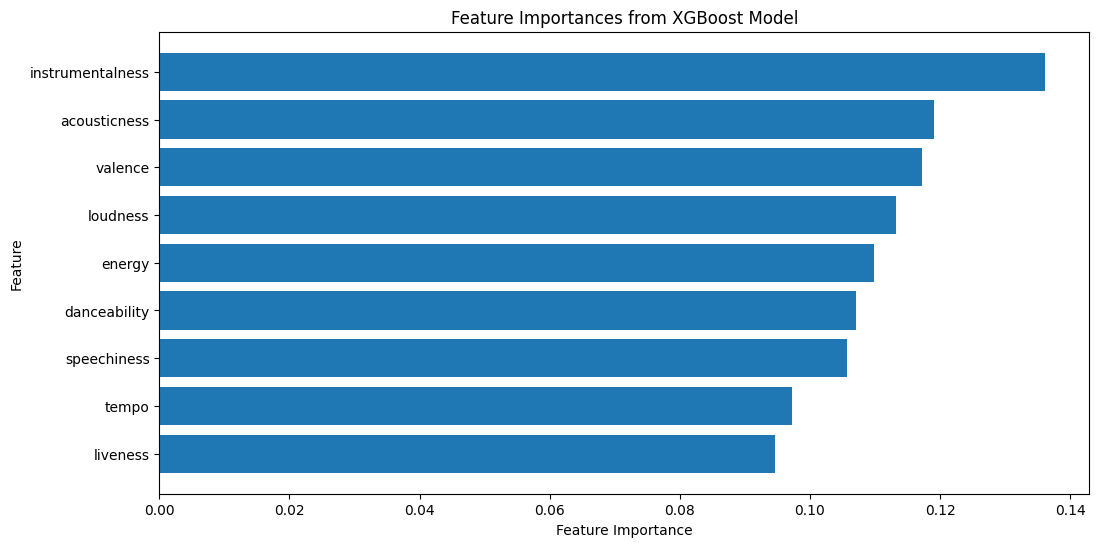

In [16]:
# Calculate feature importance
feature_importances = xgb_model.feature_importances_

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the feature importances
print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from XGBoost Model')
plt.gca().invert_yaxis()
plt.show()